In [7]:
import pandas as pd
import numpy as np
import haversine as hs
import gower
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import math


In [8]:
from shapely.geometry import Point, Polygon
import fiona
from shapely.geometry import MultiPoint, Point, Polygon,shape
from shapely.geometry.polygon import Polygon
import pandas as pd
from shapely.geometry import Point, shape, MultiPolygon
from geopandas import GeoDataFrame
import fiona
from collections import OrderedDict
import geopandas

In [9]:
# Functions

def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

def min_distance(df1,df2,columnname):
    df1[columnname] = 100

    for _,row in df2.iterrows():
        df1['mindistance'] = df1['coords'].apply(lambda x: distance_from(row.coords,x)) 
        df1[columnname] = np.where((df1['mindistance'] < df1[columnname]),df1['mindistance'],df1[columnname])
        
    return df1    

def point_within(df1,df2):
    for index in range(len(df1)):
        for row in range(len(df2)):
            df1.loc[index,'within'] = is_within(df1.loc[index,'coords_invert'],df2.loc[row,'geometry']) 
            if df1.loc[index,'within'] == True:
                df1.loc[index,'id2'] = df2.loc[row,'id']
    return df1    

def is_within(punto,poligono):
    punto = Point(punto)
    return punto.within(poligono)

def min_distance_to_poly(df1,df2):
    polygon = df2.geometry
    for index in range(len(df1)):
        indice = polygon.distance(Point(df1.loc[index,'coords_invert'])).sort_values().index[0]
        df1.loc[index,'nivel_ruido'] = df2.leyenda[indice]
    return df1  

def surface_eq(df1):
    for index in range(len(df1)):
        if math.isnan(df1.loc[index,'surface_covered']):
            df1.loc[index,'surface_covered'] = df1.loc[index,'surface_total']
            print("nan surface_covered")
        if math.isnan(df1.loc[index,'surface_total']):
            df1.loc[index,'surface_total'] = df1.loc[index,'surface_covered']
            print("nan surface_total")

    return df1

def findInOutDegree(adjList, n):
     
    _in = [0] * n
    out = [0] * n
 
    for i in range(0, len(adjList)):
 
        List = adjList[i]
 
        # Outdegree generado por la cantidad de vecinos por vector
        out[i] = len(List)
        for j in range(0, len(List)):
 
            # Indegree generado por la cantidad de apariciones 
            #de un punto en la lista de vecinos de los demas puntos
            _in[List[j]] += 1
 
    print("Vertex\tIn\tOut")
    for k in range(0, n):
        print(str(k) + "\t" + str(_in[k]) +
                       "\t" + str(out[k]))
    return _in

In [4]:
subtes_df = pd.read_csv ('data/estaciones-de-subte.csv')
data = pd.read_csv ('data/ar_properties.csv')
ferrocarriles_df = pd.read_csv('data/estaciones-de-ferrocarril.csv')
farmacias_df = pd.read_csv('data/farmacias.csv')
estadios_df = pd.read_csv('data/estadios.csv')
ruido_df = pd.read_csv('data/mapa_de_ruido_nocturno.csv')

In [5]:
data['coords'] = list(zip(data.lat, data.lon))
subtes_df['coords'] = list(zip(subtes_df.lat, subtes_df.long))
ferrocarriles_df['coords'] = list(zip( ferrocarriles_df.lat, ferrocarriles_df.long))
farmacias_df['coords'] = list(zip(farmacias_df.lat, farmacias_df.long))
estadios_df['coords'] = list(zip(estadios_df.lat, estadios_df.long))
data['coords_invert'] = list(zip(data.lon,data.lat))

In [6]:
data = data[(data.l2 == "Capital Federal")&(data.operation_type == "Venta")&(data.end_date != "9999-12-31")&(data.property_type=="Departamento")&(data.surface_total < 1000)]

In [7]:
#data = data.head(100)
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'level_0':'index'})

In [ ]:
# data_fraction = min_distance(data_fraction,subtes_df,'min_dist_subte')
# data_fraction = min_distance(data_fraction,ferrocarriles_df,'min_dist_ferrocarril')
# data_fraction = min_distance(data_fraction,farmacias_df,'min_dist_farmacia')
# data_fraction = min_distance(data_fraction,estadios_df,'min_dist_estadio')

data = min_distance(data,subtes_df,'min_dist_subte')
print("done with first part")
data = min_distance(data,ferrocarriles_df,'min_dist_ferrocarril')
print("done with second part")
data = min_distance(data,farmacias_df,'min_dist_farmacia')
print("done with third part")
data = min_distance(data,estadios_df,'min_dist_estadio')
print("done with fourth part")


In [15]:
geo_ruido_nocturno = geopandas.read_file('data/mapa_de_ruido_nocturno.csv')
geo_ruido_nocturno = geo_ruido_nocturno.reset_index()
geo_ruido_nocturno = geo_ruido_nocturno.rename(columns={"index":"id"})


In [16]:
#Reemplazo esta funcion por una de distancia que arroja mejor resultado
#data_final = point_within(data,geo_ruido_nocturno)
#data_final = pd.merge(data_final,geo_ruido_nocturno[['id','leyenda']],left_on='id2',right_on='id', how='left')

data_final = min_distance_to_poly(data,geo_ruido_nocturno)


In [ ]:
data_final[["rooms","bathrooms","bedrooms"]] =  data_final[["rooms","bathrooms","bedrooms"]].fillna(0)

#Elimino variables que no aportan al dataset
cluster_data = data_final.drop(['index', 'start_date', 'end_date','created_on','l1','l2','l4', 'l5', 'l6','description','title','ad_type','currency','price_period','operation_type','mindistance','coords_invert'], axis=1)

#arreglo NaNs en surface data
cluster_data = surface_eq(cluster_data)
cluster_data = cluster_data.dropna()

In [9]:
#To download data to csv
#cluster_data.to_csv('data_final.csv')
#To load data from csv
cluster_data = pd.read_csv('data_final_with_outliers_2.csv')

In [ ]:
#Adding currency wich got lost
data = pd.read_csv ('data/ar_properties.csv')
curr = data[['id', 'currency']]
cluster_data_final = pd.merge(cluster_data, curr, how='left', left_on = 'id', right_on = 'id')

In [11]:
#Limpio el dataset
cluster_data = cluster_data[(cluster_data.surface_total < 350)]
cluster_data = cluster_data[(cluster_data.bedrooms != -1)]
cluster_data = cluster_data[(cluster_data.surface_total > 10)]
cluster_data = cluster_data[(cluster_data.surface_covered < 350)]
cluster_data = cluster_data.drop(['Unnamed: 0'], axis=1)
cluster_data = cluster_data[(cluster_data.price != 0)]
#cluster_data = cluster_data[(cluster_data.price >= 5000)]
cluster_data = cluster_data[(cluster_data.price >= 6000)]
cluster_data = cluster_data_final[(cluster_data_final.currency == 'USD')]
cluster_data = cluster_data[(cluster_data.price < 2000000 )]
cluster_data = cluster_data[(cluster_data.bedrooms < 12)]
cluster_data = cluster_data[(cluster_data.rooms < 12)]
cluster_data = cluster_data[(cluster_data.bathrooms < 6)]

In [112]:
#To save data to dataset final
cluster_data.to_csv('data_final_with_outliers_2.csv')

# Aqui comienza la aplicacion de algoritmos

In [83]:
from sklearn.preprocessing import LabelEncoder


# Create a LabelEncoder object
le = LabelEncoder()

# Transform the categorical variables into numerical
cluster_data['nivel_ruido_encoded'] = le.fit_transform(cluster_data['nivel_ruido'])
cluster_data['id_encoded'] = le.fit_transform(cluster_data['id'])


In [230]:
#Using SKLearn for Isolation forest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

#First Attemp with basic variables 
X = cluster_data[[ 'lat','lon','rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price']]

# Fit Isolation Forest model to data
clf = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
clf.fit(X)

# Predict outliers
y_pred = clf.predict(X)



/opt/miniconda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [231]:
#Saving the data into the Dataframe for extraction
cluster_data["iforest_less_variables_scores"] = clf.score_samples(X)
cluster_data["iforest_less_variables"] = y_pred

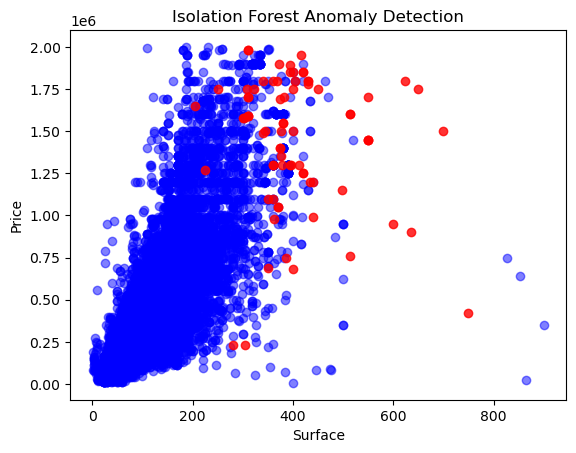

In [215]:
# Plot the results (Price-Surface)
plt.scatter(X[y_pred == -1].iloc[:, 6], X[y_pred == -1].iloc[:, 7], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1].iloc[:, 6], X[y_pred == 1].iloc[:, 7], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

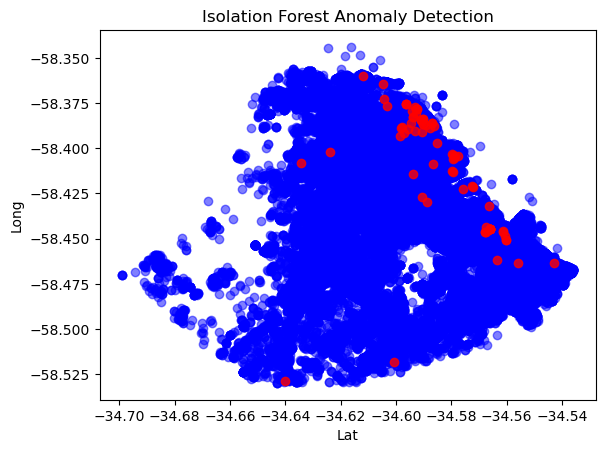

In [144]:
# Plot the results (Lat-Long)

plt.scatter(X[y_pred == -1].iloc[:, 0], X[y_pred == -1].iloc[:, 1], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1].iloc[:, 0], X[y_pred == 1].iloc[:, 1], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')
plt.show()

In [250]:
#Second Attemp with more variables 
X = cluster_data[[ 'lat','lon','rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price','min_dist_subte', 'min_dist_ferrocarril', 'min_dist_farmacia',
       'min_dist_estadio','nivel_ruido_encoded']]

# Fit Isolation Forest model to data
clf = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
clf.fit(X)

# Predict outliers"
y_pred = clf.predict(X)


/opt/miniconda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [251]:
cluster_data["iforest_more_variables_scores"] = clf.score_samples(X)
cluster_data["iforest_more_variables"] = y_pred

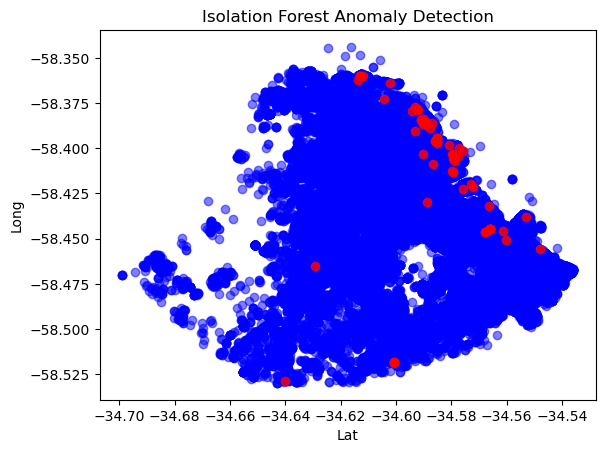

In [244]:


# Plot the results with more variables (Lat-Long)
plt.scatter(X[y_pred == -1].iloc[:, 0], X[y_pred == -1].iloc[:, 1], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1].iloc[:, 0], X[y_pred == 1].iloc[:, 1], c = 'blue', alpha = 0.5, zorder = 1)

# plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=np.where(y_pred==1, 'blue', 'red'), alpha=0.5,  zorder=1)

plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')

# for i, txt in enumerate(X.id_encoded):
#     plt.annotate(txt, (X.iloc[i, 0], X.iloc[i, 1]))
plt.show()

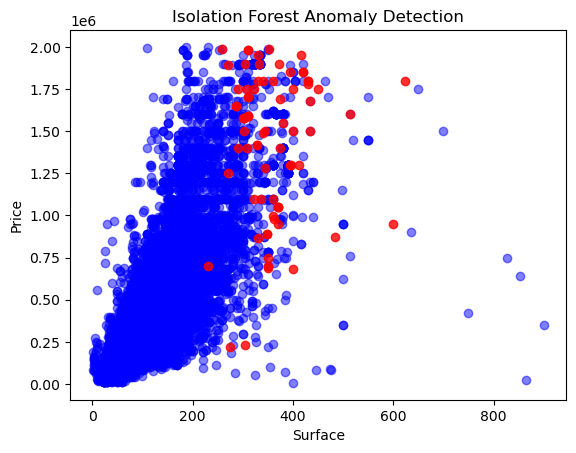

In [245]:
# Plot the results (Price-Surface)
plt.scatter(X[y_pred == -1].iloc[:, 6], X[y_pred == -1].iloc[:, 7], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1].iloc[:, 6], X[y_pred == 1].iloc[:, 7], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

In [254]:
#Testing LOF
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

BVariables = [ 'lat','lon','rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price']
scaler = MinMaxScaler()

#First Attemp with basic variables 
X = scaler.fit_transform(cluster_data[BVariables])


# Fit the LOF model
clf = LocalOutlierFactor(n_neighbors=11, contamination=0.001)
y_pred = clf.fit_predict(X)
scores = clf.negative_outlier_factor_




In [256]:
cluster_data["lof_less_variables"] = y_pred
cluster_data["lof_less_variables_scores"] = clf.negative_outlier_factor_

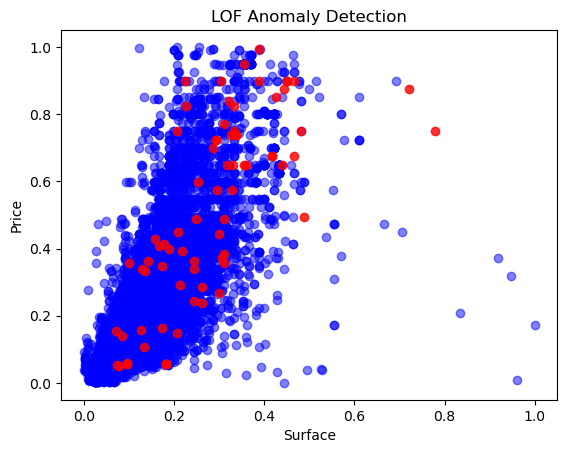

In [255]:
#LOF Price x Surface - Less variables

# # Plot the results

plt.scatter(X[y_pred == -1][:, 6], X[y_pred == -1][:, 7], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1][:, 6], X[y_pred == 1][:, 7], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('LOF Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

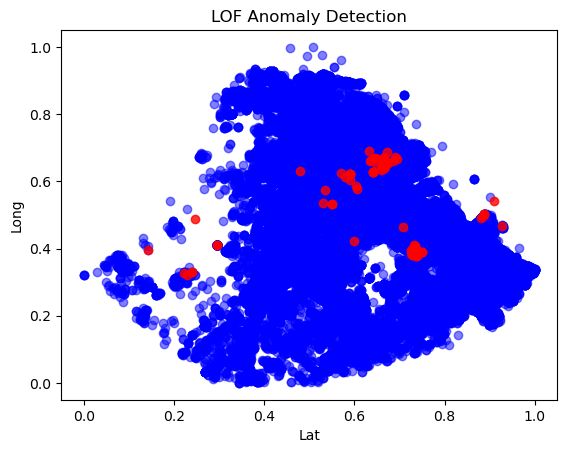

In [196]:
#LOF Lat x Long - Less variables

# # Plot the results

plt.scatter(X[y_pred == -1][:, 0], X[y_pred == -1][:, 1], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('LOF Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')
plt.show()

In [260]:
#Testing LOF - With more variables
from sklearn.neighbors import LocalOutlierFactor

#Second Attemp with more variables 
MVariables = [ 'lat','lon','rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price','min_dist_subte', 'min_dist_ferrocarril', 'min_dist_farmacia',
       'min_dist_estadio','nivel_ruido_encoded']

scaler = MinMaxScaler()

#First Attemp with basic variables 
X = scaler.fit_transform(cluster_data[MVariables])


# Fit the LOF model
clf = LocalOutlierFactor(n_neighbors=11, contamination=0.001)
y_pred = clf.fit_predict(X)
scores = clf.negative_outlier_factor_


In [261]:
cluster_data["lof_more_variables"] = y_pred

In [262]:
cluster_data["lof_more_variables_scores"] = clf.negative_outlier_factor_

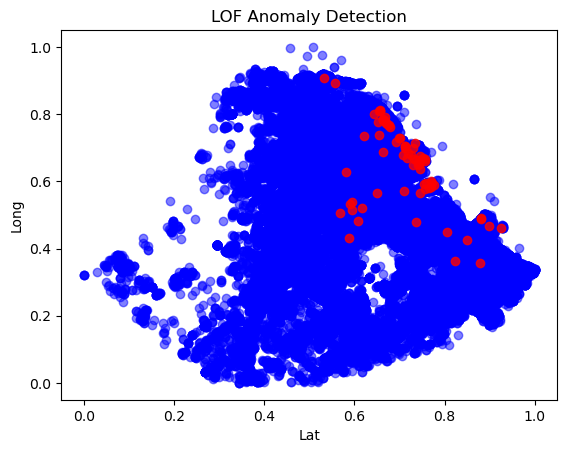

In [263]:
#LOF Lat x Long - More variables

# # Plot the results

plt.scatter(X[y_pred == -1][:, 0], X[y_pred == -1][:, 1], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('LOF Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')
plt.show()

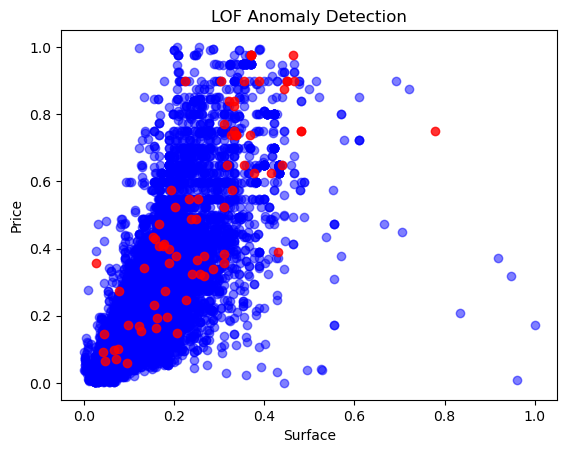

In [264]:
#LOF Price x Surface - More variables

# # Plot the results

plt.scatter(X[y_pred == -1][:, 6], X[y_pred == -1][:, 7], c = 'red', alpha = 0.8, zorder = 100)
plt.scatter(X[y_pred == 1][:, 6], X[y_pred == 1][:, 7], c = 'blue', alpha = 0.5, zorder = 1)
plt.title('LOF Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

In [96]:
#Testing ODIN
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import NearestNeighbors

BVariables = ['lat','lon', 'rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price']
scaler = MinMaxScaler()

#First Attemp with basic variables 
tempset = cluster_data[BVariables]


# Temporary rows to understand the algorithm behaviour
# list_row = [-34.613794, -58.425989, 0, 0, 0, 10,5,3000000]
# list_row2 = [-34.613793, -58.425909, 1, 1, 1, 2000,2000,30000]
# list_row3 = [-34.613795, -58.425100, 12, 10, 10, 40,50,30000]

# tempset.loc[len(tempset)] = list_row
# tempset.loc[len(tempset)] = list_row2
# tempset.loc[len(tempset)] = list_row3



X = scaler.fit_transform(tempset)


# Calculate in-degree number
k = 30 # Number of nearest neighbors
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, indices = nn.kneighbors(X)

#We delete the first element of each array to apply the function
indices_2 = [np.delete(u,0) for u in indices]

#Find out indegree numbers
j = np.array(findInOutDegree(indices_2,75369))

In [99]:
#Set the ouliers
outliers = X[j < 1]


In [ ]:
#Check results
temp = tempset
temp['odin'] = j
temp[j == 0].sort_values(by=['price'])

In [101]:
#Save the values in dataframe
cluster_data["odin_less_variables_scores"] = j
cluster_data.loc[cluster_data['odin_less_variables_scores'] < 1, "odin_less_variables"] = -1
cluster_data.loc[cluster_data['odin_less_variables_scores'] > 1, "odin_less_variables"] = 1

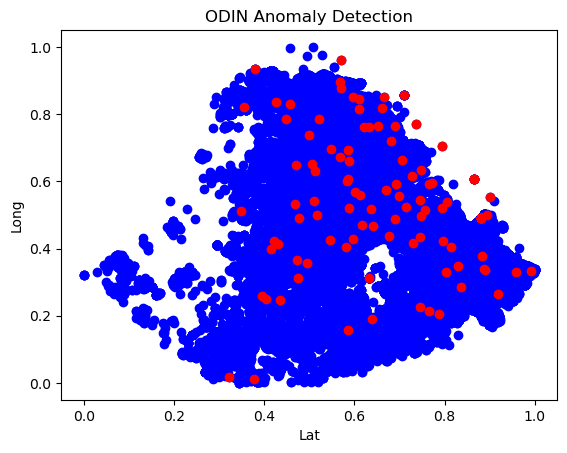

In [102]:
plt.scatter(X[:, 0], X[:, 1], c='b', cmap='coolwarm', label='Normal Data')
plt.scatter(outliers[:, 0], outliers[:, 1], c='r', label='Outliers')
plt.title('ODIN Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')
plt.show()

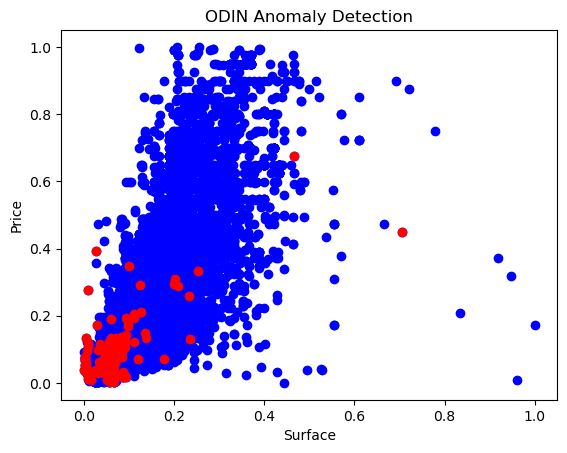

In [103]:
plt.scatter(X[:, 6], X[:, 7], c='b', cmap='coolwarm', label='Normal Data')
plt.scatter(outliers[:, 6], outliers[:, 7], c='r', label='Outliers')
plt.title('ODIN Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

In [104]:
from sklearn.neighbors import NearestNeighbors


BVariables = [ 'lat','lon','rooms','bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price','min_dist_subte', 'min_dist_ferrocarril', 'min_dist_farmacia',
       'min_dist_estadio','nivel_ruido_encoded']

scaler = MinMaxScaler()

#First Attemp with basic variables 
X = scaler.fit_transform(cluster_data[BVariables])

# Calculate in-degree number
k = 30 # Number of nearest neighbors
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, indices = nn.kneighbors(X)

indices_2 = [np.delete(u,0) for u in indices]

j = np.array(findInOutDegree(indices_2,75369))

In [107]:
outliers = X[j < 1]


In [111]:
cluster_data["odin_more_variables_scores"] = j
cluster_data.loc[cluster_data['odin_more_variables_scores'] < 1, "odin_more_variables"] = -1
cluster_data.loc[cluster_data['odin_more_variables_scores'] > 1, "odin_more_variables"] = 1

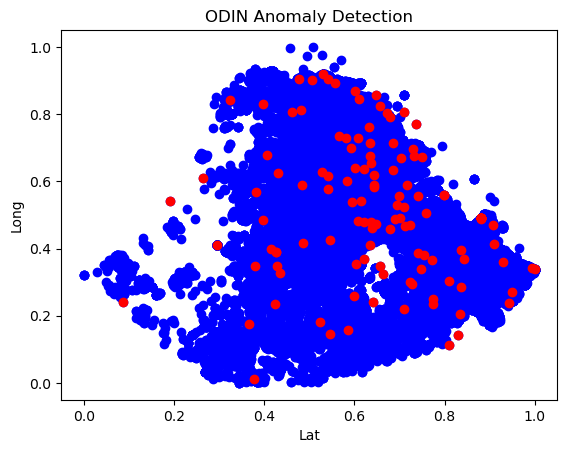

In [108]:
plt.scatter(X[:, 0], X[:, 1], c='b', cmap='coolwarm', label='Normal Data')
plt.scatter(outliers[:, 0], outliers[:, 1], c='r', label='Outliers')
plt.title('ODIN Anomaly Detection')
plt.xlabel('Lat')
plt.ylabel('Long')
plt.show()

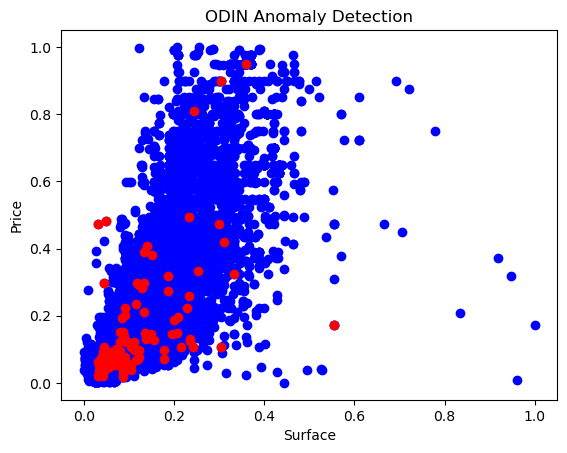

In [109]:
plt.scatter(X[:, 6], X[:, 7], c='b', cmap='coolwarm', label='Normal Data')
plt.scatter(outliers[:, 6], outliers[:, 7], c='r', label='Outliers')
plt.title('ODIN Anomaly Detection')
plt.xlabel('Surface')
plt.ylabel('Price')
plt.show()

In [114]:
#Validating data

# temp = cluster_data[BVariables]
# temp['odin'] = in_degree
#cluster_data[j < 1]

/opt/miniconda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


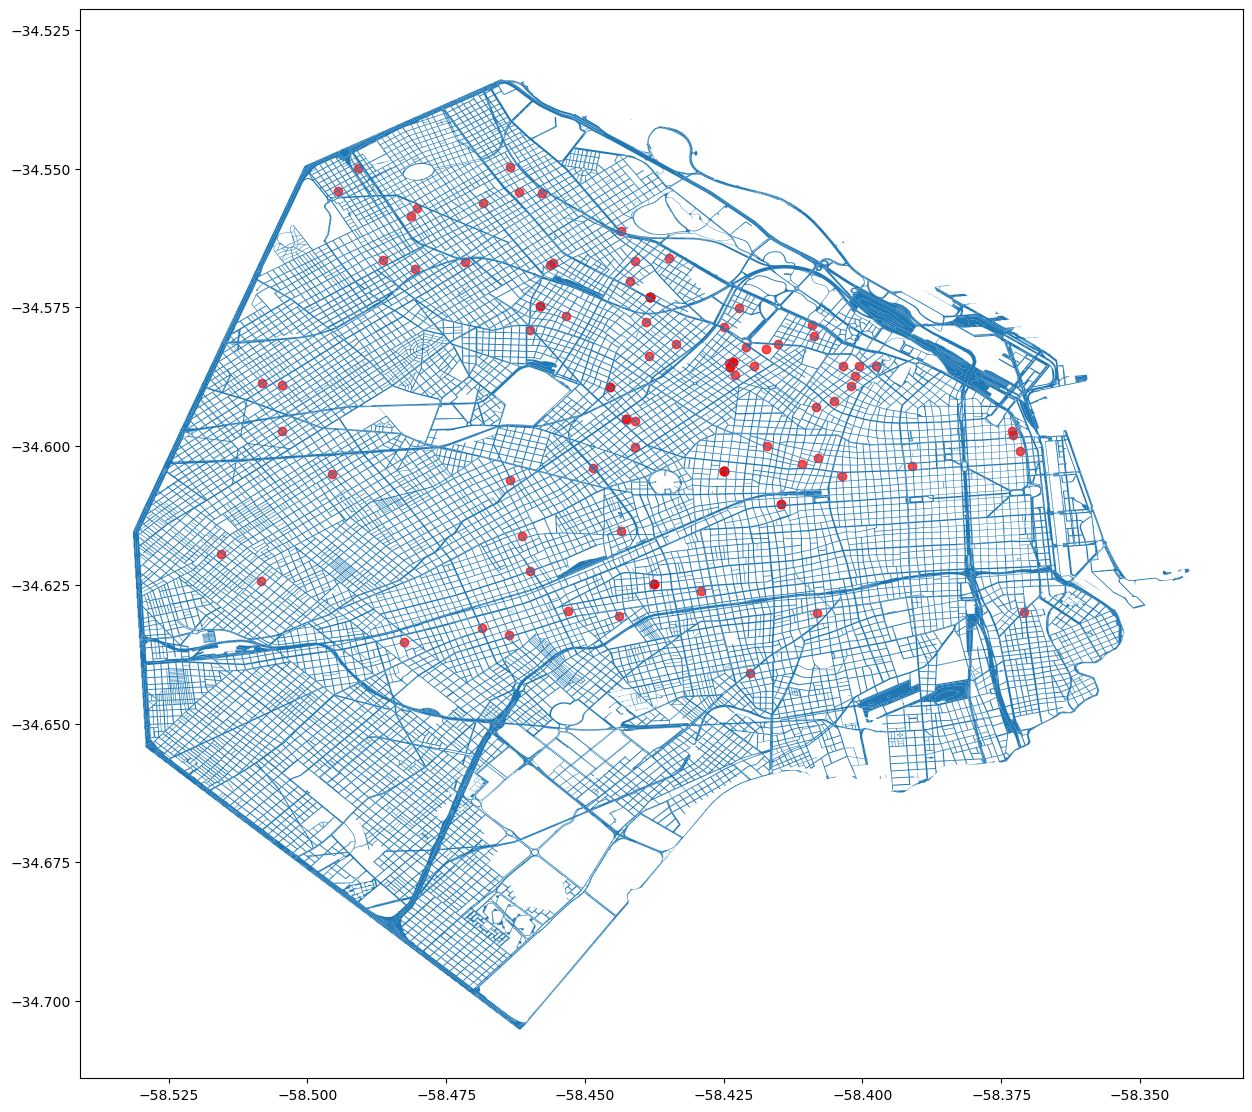

In [46]:
#Dibujo Departamentos sobre mapa de ruido nocturno
polygon = geo_ruido_nocturno.geometry
geometryc = [Point(xy) for xy in data_final.coords_invert]
gdf = geopandas.GeoDataFrame(data_final, geometry=geometryc)

fig, ax = plt.subplots(figsize=(15, 15))
gdf.geometry.plot(ax=ax, alpha=0.7, color="red")
polygon.plot(ax=ax)


In [ ]:
!pip install DDoutlier

In [ ]:
!pip install solitude

In [ ]:
!pip install haversine

In [ ]:
!pip install shapely

In [ ]:
!pip install geopandas

In [ ]:
!pip install gower

In [ ]:
!pip install seaborn==0.11.0

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
